# Tassos *Gerusalemme*-Projekt
Torquato Tasso überarbeitet seine 1581 als Raubdruck erschienene *Gerusalemme Liberata* mehr als zehn Jahre lang. 1593 erscheint die einzige vom Autor autorisierte Version der *Gersualemme*-Dichtung unter dem Titel *Gerusalemme Conquistata* (Tasso 1593). Diese hatte bei weitem nicht den Erfolg der *Liberata* und wurde in der Forschung folglich kaum berücksichtigt. Während schon in einigen Ausgaben der *Gerusalemme Liberata* des 18. und 19. Jahrhunderts die ergänzten Passagen aus der *Gerusalemme Conquistata* abgedruckt wurden, ist m.W. die von Francesco Flora und Ettora Mazzali besorgte, seltene, klug strukturierte, aber materiell schlecht produzierte Ausgabe *La Gerusalemme liberata e La Gerusalemme conquistata: edizione integrale a raffronto* (Mailand: Malfasi 1952-1953) die einzige synoptische Ausgabe der beiden Werke bzw. Textversionen. Da durch wegweisende Arbeiten insbesondere Gigantes und Girardis das Verhältnis von *Conquistata* und *Liberata* stärker in den Fokus der Forschung gerückt wurde, soll mit der hier maschinell erstellten tendenziell synoptischen Darstellung der beiden Werke ein Hilfsmittel zur Verfügung gestellt, das die vergleichende Betrachtung der beiden Werke etwas erleichtert.   

## Import

In [1]:
# Import benötigter Module
from glob import glob
import re
from lxml import etree as ET
from difflib import SequenceMatcher as SM
import csv
%matplotlib notebook
import matplotlib.pyplot as plt
import collections
import numpy as np
#import xml.etree.ElementTree as ET

In [2]:
# Funktionen
def gl_stelle(index):
    string = "{t} (GL {c} {o},{v})".format(
        t=out['Gerusalemme liberata'][i[0]]['testo'],
        c=out['Gerusalemme liberata'][i[0]]['canto'],
        o=out['Gerusalemme liberata'][i[0]]['ottava'],
        v=out['Gerusalemme liberata'][i[0]]['verso']
    )
    return string
def gc_stelle(index):
    string = "{t} (GC {c} {o},{v})".format(
        t=out['Gerusalemme conquistata'][i[1]]['testo'],
        c=out['Gerusalemme conquistata'][i[1]]['canto'],
        o=out['Gerusalemme conquistata'][i[1]]['ottava'],
        v=out['Gerusalemme conquistata'][i[1]]['verso']
    )
    return string

Die TEI-XML-Dateien der *Gerusalemme Liberata* und *Conqusitata* werden zunächst von www.bibliotecaitaliana.it heruntergeladen und in diesem Verzeichnis abgelegt.

In [3]:
files = ['http://backend.bibliotecaitaliana.it/wp-json/muruca-core/v1/xml/bibit001501','http://backend.bibliotecaitaliana.it/wp-json/muruca-core/v1/xml/bibit000260']

## Vorbereitung der Daten
Die Texte werden nach Gesang bzw. Buch, Oktave und Vers zitiert. Diese Informationen sind in der TEI implizit hinterlegt. Im Folgenden werden beide Texte versweise samt Stelleninformation eingelesen.

In [4]:
out = {}
for f in files:
    tree = ET.parse(f)
    title = tree.xpath('/TEI.2/teiHeader/fileDesc/titleStmt/title')[0].text
    out[title] = []
    for l in tree.xpath('//l'):
        text = l.text
        m = re.match(r'text/body/div1\[(\d+)\]/lg\[(\d+)\]/l\[(\d+)\]',tree.getelementpath(l))
        canto, ottava, verso = m.group(1), m.group(2), m.group(3)
        out[title].append({ 'canto' : canto, 'ottava' : ottava, 'verso' : verso, 'testo' : text})
        

## Ähnlichkeitsberechnung (Option A – sehr zeitaufwendig!)
Nun wird für alle Permutationen ein einfaches String-Delta berechnet und in einem zweidimensionalen Array gespeichert, wobei die x-Achse die *Gerusalemme Liberata*, die y-Achse die *Conquistata* enthält. Es wurden – oberflächlich – auch die Ähnlichkeitsmetriken des `jellyfish`-Moduls erprobt, doch schien der eingebaute `difflib`-Alogrithmus ausreichend trennscharf zu sein. Als guter Cutoff-Wert bietet sich erfahrungsgemäß 0.7 an. Die `ratio_matrix` speichert aber alle Ähnlichkeitsrelationen zwischen allen Versen der beiden Werke. Die Berechnung der 336M Deltas ist relativ teuer und dauert entsprechend lange (die Permutationen für einen Vers dauern etwas weniger als 2 Sekunden, was bei gut 15k Versen einer Rechenzeit von mehr als 8 Std. entspricht).
Nach Abschluss der Berechnung wird das Ergebnis in `ratio_matrix.csv` geschrieben.

In [50]:
ratio_matrix = [] # 2d-Array
for gl in enumerate(out['Gerusalemme liberata']):
    for gc in enumerate(out['Gerusalemme conquistata']):
        sim = SM(None, gl[1]['testo'], gc[1]['testo']).ratio()
        if sim > 0.6:
            ratio_matrix.append((gl[0],gc[0],sim))
            print((gl[0],gc[0],sim))
        

(0, 0, 0.6301369863013698)
(0, 4472, 0.6172839506172839)
(0, 16009, 0.64)
(0, 18540, 0.6111111111111112)
(2, 2, 0.7804878048780488)
(3, 3, 0.704225352112676)
(3, 4365, 0.6301369863013698)


KeyboardInterrupt: 

In [66]:
f = open('ratio_matrix.csv', 'w')

with f:
    writer = csv.writer(f)
    for row in ratio_matrix:
        writer.writerow(row)

## Option B (schnell)
Alternativ kann auch das Ergebnis der teuren Berechnung aus der vorbereiteten CSV geladen werden

In [51]:
with open('ratio_matrix.csv', 'r') as CSV:
    ratio_matrix = []
    for i in list(csv.reader(CSV,  delimiter=',', quotechar='\'')):
        a = int(i[0])
        b = int(i[1])
        c = float(i[2])
        ratio_matrix.append([a,b,c])

Nachtragen der ähnlichen Verse in das Dictionary

In [52]:
for i in ratio_matrix:
    # Für GL
    if 'sim' in out['Gerusalemme liberata'][i[0]].keys():
        out['Gerusalemme liberata'][i[0]]['sim'].append(i)
    else:
        out['Gerusalemme liberata'][i[0]]['sim'] = [i]
    # Für GC
    if 'sim' in out['Gerusalemme conquistata'][i[1]].keys():
        out['Gerusalemme conquistata'][i[1]]['sim'].append(i)
    else:
        out['Gerusalemme conquistata'][i[1]]['sim'] = [i]

Konstruktion zweier alternativer verschachtelter Dictionaries (rev_##\[Buch\]\[Oktave\]\[Vers\])

In [490]:
rev_gl = {}
for i in out['Gerusalemme liberata']:
    if not i['canto'] in rev_gl.keys():
        rev_gl[i['canto']] = {}
    else:
        if not i['ottava'] in rev_gl[i['canto']].keys():
            rev_gl[i['canto']][i['ottava']] = {}
        else:
            rev_gl[i['canto']][i['ottava']][i['verso']] = i['testo']

In [493]:
rev_gc = {}
for i in out['Gerusalemme conquistata']:
    if not i['canto'] in rev_gl.keys():
        rev_gl[i['canto']] = {}
    else:
        if not i['ottava'] in rev_gl[i['canto']].keys():
            rev_gl[i['canto']][i['ottava']] = {}
        else:
            rev_gl[i['canto']][i['ottava']][i['verso']] = i['testo']

In [503]:
def output_ottava(rev_dict,buch,oktave):
    li = [rev_dict[str(buch)][str(oktave)][str(i)] for i in sorted(rev_dict[str(buch)][str(oktave)].keys())]
    return li

## Export

Ausgabe als reiner Text nach STDOUT

In [333]:
thresh = 0.8
for i in out['Gerusalemme liberata']:
    print("GL {c} {o},{v} \t {t}".format(c=i['canto'],o=i['ottava'],v=i['verso'],t=i['testo']))
    if 'sim' in i.keys():
        for j in i['sim']:
            if j[2] > thresh:
                print("\t\tGC {c} {o},{v} \t {t} (SIM: {sim})".format(
                      c=out['Gerusalemme conquistata'][j[1]]['canto'],
                      o=out['Gerusalemme conquistata'][j[1]]['ottava'],
                      v=out['Gerusalemme conquistata'][j[1]]['verso'],
                      t=out['Gerusalemme conquistata'][j[1]]['testo'],
                      sim=j[2]
                ))

GL 1 1,1 	 Canto l'arme pietose e 'l capitano
GL 1 1,2 	 che 'l gran sepolcro liberò di Cristo.
GL 1 1,3 	 Molto egli oprò co 'l senno e con la mano, 
GL 1 1,4 	 molto soffrì nel glorioso acquisto; 
GL 1 1,5 	 e in van l'Inferno vi s'oppose, e in vano 
GL 1 1,6 	 s'armò d'Asia e di Libia il popol misto. 
GL 1 1,7 	 Il Ciel gli diè favore, e sotto a i santi 
GL 1 1,8 	 segni ridusse i suoi compagni erranti. 
GL 1 2,1 	 O Musa, tu che di caduchi allori 
GL 1 2,2 	 non circondi la fronte in Elicona, 
GL 1 2,3 	 ma su nel cielo infra i beati cori 
GL 1 2,4 	 hai di stelle immortali aurea corona, 
GL 1 2,5 	 tu spira al petto mio celesti ardori, 
GL 1 2,6 	 tu rischiara il mio canto, e tu perdona 
GL 1 2,7 	 s'intesso fregi al ver, s'adorno in parte 
GL 1 2,8 	 d'altri diletti, che de' tuoi le carte. 
GL 1 3,1 	 Sai che là corre il mondo ove più versi 
GL 1 3,2 	 di sue dolcezze il lusinghier Parnaso, 
GL 1 3,3 	 e che 'l vero, condito in molli versi, 
GL 1 3,4 	 i più schivi allettando ha 

GL 5 32,5 	 ode i sospiri e le querele e 'l pianto 
		GC 6 45,5 	 Ode i sospiri e le querele e 'l pianto,  (SIM: 0.9620253164556962)
GL 5 32,6 	 che molti fan sovra il guerrier ucciso. 
		GC 6 45,6 	 che molti fan sopra il guerriero ucciso.  (SIM: 0.9629629629629629)
GL 5 32,7 	 Stupido chiede: – Or qui, dove men lece, 
GL 5 32,8 	 chi fu ch'ardì cotanto e tanto fece? – 
GL 5 33,1 	 Arnalto, un de' più cari al prence estinto, 
		GC 6 46,1 	 Arnalto, un de' piu cari al prence estinto,  (SIM: 0.9772727272727273)
GL 5 33,2 	 narra (e 'l caso in narrando aggrava molto) 
GL 5 33,3 	 che Rinaldo l'uccise e che fu spinto 
		GC 6 46,3 	 che Riccardo l'uccise e fu sospinto  (SIM: 0.8493150684931506)
GL 5 33,4 	 da leggiera cagion d'impeto stolto, 
		GC 6 46,4 	 da leggiera cagion d'impeto leve;  (SIM: 0.8571428571428571)
GL 5 33,5 	 e che quel ferro, che per Cristo è cinto, 
		GC 6 46,5 	 e che quel ferro il qual per Cristo è cinto,  (SIM: 0.8735632183908046)
GL 5 33,6 	 ne' campioni di Cristo 

		GC 9 41,8 	 infiammati ne siano i duci illustri. (SIM: 0.8533333333333334)
GL 8 38,1 	 Resta che sappia tu chi sia colui 
GL 8 38,2 	 che deve de la spada esser erede. 
GL 8 38,3 	 Questi è Rinaldo, il giovenetto a cui 
GL 8 38,4 	 il pregio di fortezza ogn'altro cede. 
GL 8 38,5 	 A lui la porgi, e di' che sol da lui 
GL 8 38,6 	 l'alta vendetta il Cielo e 'l mondo chiede.>> 
GL 8 38,7 	 Or mentre io le sue voci intento ascolto, 
GL 8 38,8 	 fui da miracol novo a sé rivolto, 
GL 8 39,1 	 ché là dove il cadavero giacea 
GL 8 39,2 	 ebbi improviso un gran sepolcro scorto, 
GL 8 39,3 	 che sorgendo rinchiuso in sé l'avea, 
GL 8 39,4 	 come non so né con qual arte sorto; 
GL 8 39,5 	 e in brevi note altrui vi si sponea 
GL 8 39,6 	 il nome e la virtù del guerrier morto. 
GL 8 39,7 	 Io non sapea da tal vista levarmi, 
GL 8 39,8 	 mirando ora le lettre ed ora i marmi. 
GL 8 40,1 	 <<Qui>> disse il vecchio <<appresso a i fidi amici 
GL 8 40,2 	 giacerà del tuo duce il corpo ascoso, 
		GC 

		GC 14 98,3 	 sopra di polve il ciel gli si coperse,  (SIM: 1.0)
GL 11 76,4 	 tremò sotto la terra al moto scossa; 
		GC 14 98,4 	 tremò sotto la terra e parve scossa:  (SIM: 0.8108108108108109)
GL 11 76,5 	 e lontano appressar le genti averse 
		GC 14 98,5 	 e lontano venir le genti avverse  (SIM: 0.8405797101449275)
GL 11 76,6 	 d'alto il miraro, e corse lor per l'ossa 
		GC 14 98,6 	 d'alto il mirâro, e corse lor per l'ossa  (SIM: 0.975609756097561)
GL 11 76,7 	 un tremor freddo e strinse il sangue in gelo. 
		GC 14 98,7 	 un timor freddo, e strinse 'l sangue in gelo;  (SIM: 0.9130434782608695)
GL 11 76,8 	 Egli alzò tre fiate il grido al cielo. 
		GC 14 98,8 	 egli alzò tre fiate il grido al cielo. (SIM: 0.961038961038961)
GL 11 77,1 	 Conosce il popol suo l'altera voce 
GL 11 77,2 	 e 'l grido eccitator de la battaglia, 
GL 11 77,3 	 e riprendendo l'impeto veloce 
		GC 14 100,3 	 e, riprendendo l'impeto veloce,  (SIM: 0.967741935483871)
GL 11 77,4 	 di novo ancora a la tenzon si 

GL 15 49,8 	 lascia quel varco libero e s'appiatta. 
		GC 12 89,8 	 lascia quel varco libero, e s'appiatta. (SIM: 0.9743589743589743)
GL 15 50,1 	 Più suso alquanto il passo a lor contende 
		GC 12 90,1 	 Più suso, alquanto il passo a lor contende  (SIM: 0.9882352941176471)
GL 15 50,2 	 fero leon che rugge e torvo guata, 
GL 15 50,3 	 e i velli arrizza, e le caverne orrende 
GL 15 50,4 	 de la bocca vorace apre e dilata. 
GL 15 50,5 	 Si sferza con la coda e l'ire accende, 
		GC 12 90,5 	 si sferza con la coda, e l'ira accende;  (SIM: 0.9113924050632911)
GL 15 50,6 	 ma non è pria la verga a lui mostrata 
GL 15 50,7 	 ch'un secreto spavento al cor gli agghiaccia 
GL 15 50,8 	 l'ira e 'l nativo orgoglio, e 'n fuga il caccia. 
GL 15 51,1 	 Segue la coppia il suo camin veloce, 
		GC 12 91,1 	 Seguia la coppia il suo cammin veloce:  (SIM: 0.9210526315789473)
GL 15 51,2 	 ma formidabile oste han già davante 
GL 15 51,3 	 di guerrieri animai, vari di voce, 
GL 15 51,4 	 vari di moto, vari di

		GC 23 69,3 	 e quei ch'ardir non armi, arme non copra, (SIM: 0.963855421686747)
GL 19 32,4 	 caccia co 'l guardo e con l'orribil voce. 
		GC 23 69,4 	 caccia co 'l guardo e con l'orribil voce. (SIM: 0.9879518072289156)
GL 19 32,5 	 Vedresti, di valor mirabil opra, 
		GC 23 69,5 	 Vedresti di valor mirabil opra, (SIM: 0.96875)
GL 19 32,6 	 come or disprezza, ora minaccia, or noce, 
		GC 23 69,6 	 come or disprezza, ora minaccia, or nuoce (SIM: 0.963855421686747)
GL 19 32,7 	 come con rischio disegual fugati 
		GC 23 69,7 	 e con periglio disegual fugati (SIM: 0.8253968253968254)
GL 19 32,8 	 sono egualmente pur nudi ed armati. 
GL 19 33,1 	 Già co 'l più imbelle vulgo anco ritratto 
		GC 23 70,1 	 Pria co 'l più debol volgo anco ritratto (SIM: 0.8048780487804879)
GL 19 33,2 	 s'è non picciolo stuol del più guerriero 
GL 19 33,3 	 nel tempio che, più volte arso e disfatto, 
		GC 23 70,3 	 nel tempio, che più volte arso e disfatto, (SIM: 0.9647058823529412)
GL 19 33,4 	 si noma ancor, d

Ausgabe in Html-Datei. Zunächst die *Liberata*

In [592]:
root = ET.Element('html')
head = ET.SubElement(root,'head')
css = ET.SubElement(head,'link', attrib={'rel' : "stylesheet",'type' : "text/css", 'href' : "style.css"})
body = ET.SubElement(root,'body')
h1 = ET.SubElement(body,'h1')
h1.text = "T. Tasso: Gerusalemme Liberata"
canto = 0
ottava = 0

thresh = 0.8
for i in out['Gerusalemme liberata']:
    if not i['canto'] == canto:
        table = ET.SubElement(body,'table', attrib={'class':"canto"})
        thead = ET.SubElement(table,'thead')
        th = ET.SubElement(thead,'th')
        th.text = i['canto']
        canto = i['canto']
    if not i['ottava'] == ottava:
        ott_head = ET.SubElement(table,'tr', attrib={'class':'ottava'})
        ott_head_td = ET.SubElement(ott_head,'td', attrib={'colspan' : '3'})
        ott_head_td.text = "GL {}, {}".format(i['canto'],i['ottava'])
        ottava = i['ottava']
    row=ET.SubElement(table,'tr')
    loc=ET.SubElement(row,'td', attrib={'class':"stellenangabe"})
    loc.text="GL {c} {o},{v}".format(c=i['canto'],o=i['ottava'],v=i['verso'])
    ver=ET.SubElement(row,'td')
    ver.text=i['testo']
    if 'sim' in i.keys():
        sim=ET.SubElement(row,'td')
        ol = ET.SubElement(sim,'ol', attrib={'class' : 'parallels'})
        loci_sim = [j for j in i['sim'] if j[2] > thresh]
        for ls in loci_sim:
            li = ET.SubElement(ol,'li')
            li.text = "GC {c} {o},{v} {t} (SIM: {sim})".format(
                  c=out['Gerusalemme conquistata'][ls[1]]['canto'],
                  o=out['Gerusalemme conquistata'][ls[1]]['ottava'],
                  v=out['Gerusalemme conquistata'][ls[1]]['verso'],
                  t=out['Gerusalemme conquistata'][ls[1]]['testo'],
                  sim=round(ls[2],2)
            )

tree = ET.tostring(root)

with open("synopse-gl.html", "wb") as f:
    f.write(tree)

... dann die *Conquistata*

In [594]:
root = ET.Element('html')
head = ET.SubElement(root,'head')
css = ET.SubElement(head,'link', attrib={'rel' : "stylesheet",'type' : "text/css", 'href' : "style.css"})
body = ET.SubElement(root,'body')
h1 = ET.SubElement(body,'h1')
h1.text = "T. Tasso: Gerusalemme Conquistata"
canto = 0
ottava = 0

thresh = 0.8
for i in out['Gerusalemme conquistata']:
    if not i['canto'] == canto:
        table = ET.SubElement(body,'table', attrib={'class':"canto"})
        thead = ET.SubElement(table,'thead')
        th = ET.SubElement(thead,'th')
        th.text = i['canto']
        canto = i['canto']
    if not i['ottava'] == ottava:
        ott_head = ET.SubElement(table,'tr', attrib={'class':'ottava'})
        ott_head_td = ET.SubElement(ott_head,'td', attrib={'colspan' : '3'})
        ott_head_td.text = "GC {}, {}".format(i['canto'],i['ottava'])
        ottava = i['ottava']
    row=ET.SubElement(table,'tr')
    loc=ET.SubElement(row,'td', attrib={'class':"stellenangabe"})
    loc.text="GC {c} {o},{v}".format(c=i['canto'],o=i['ottava'],v=i['verso'])
    ver=ET.SubElement(row,'td')
    ver.text=i['testo']
    if 'sim' in i.keys():
        sim=ET.SubElement(row,'td')
        ol = ET.SubElement(sim,'ol', attrib={'class' : 'parallels'})
        loci_sim = [j for j in i['sim'] if j[2] > thresh]
        for ls in loci_sim:
            li = ET.SubElement(ol,'li')
            li.text = "GL {c} {o},{v} {t} (SIM: {sim})".format(
                  c=out['Gerusalemme liberata'][ls[0]]['canto'],
                  o=out['Gerusalemme liberata'][ls[0]]['ottava'],
                  v=out['Gerusalemme liberata'][ls[0]]['verso'],
                  t=out['Gerusalemme liberata'][ls[0]]['testo'],
                  sim=round(ls[2],2)
            )

tree = ET.tostring(root)

with open("synopse-gc.html", "wb") as f:
    f.write(tree)

In [128]:
for i in out['Gerusalemme liberata']:
    print('GL c.{c},{o},{v}: {t}'.format(c=i['canto'],o=i['ottava'],v=i['verso'],t=i['testo']))
    if 'sim' in i.keys():
        for gc in sorted(i['sim'], key=lambda x: x[2], reverse=True):
            print("{v} ({sim})".format(v = out['Gerusalemme conquistata'][gc[1]]['testo'], sim = gc[2]))


GL c.1,1,1: Canto l'arme pietose e 'l capitano
ei l'arme insieme e 'l cavalier portando, (0.64)
Io canto l'arme e 'l cavalier sovrano,  (0.6301369863013698)
Ciò detto, l'arme chiede, e 'l capo e 'l busto  (0.6172839506172839)
ecco de' tuoi l'armi pietose e l'arte: (0.6111111111111112)
GL c.1,1,2: che 'l gran sepolcro liberò di Cristo.
GL c.1,1,3: Molto egli oprò co 'l senno e con la mano, 
Molto co 'l senno e con l'invitta mano  (0.7804878048780488)
GL c.1,1,4: molto soffrì nel glorioso acquisto; 
egli adoprò nel glorïoso acquisto;  (0.704225352112676)
e fia impedito il glorïoso acquisto,  (0.6301369863013698)
il vento soffia, e vigor fa ch'acquiste  (0.6052631578947368)
GL c.1,1,5: e in van l'Inferno vi s'oppose, e in vano 
GL c.1,1,6: s'armò d'Asia e di Libia il popol misto. 
GL c.1,1,7: Il Ciel gli diè favore, e sotto a i santi 
GL c.1,1,8: segni ridusse i suoi compagni erranti. 
con gli altri suoi compagni in guerra eletti, (0.6190476190476191)
GL c.1,2,1: O Musa, tu che di caduchi

e fe' di nero sangue in terra un lago. (0.6329113924050633)
GL c.4,11,1: Né ciò gli parve assai; ma in preda a morte, 
Né ciò gli parve assai; ma in preda a morte,  (1.0)
e cede al novo assalto; e 'n preda a l'ire  (0.6136363636363636)
GL c.4,11,2: sol per farne più danno, il figlio diede. 
sol per farne più danno, il figlio ei diede.  (0.9655172413793104)
GL c.4,11,3: Ei venne e ruppe le tartaree porte, 
Quel venne e ruppe le tartaree porte,  (0.918918918918919)
Aprite, aprite le Tartaree porte,  (0.6571428571428571)
GL c.4,11,4: e porre osò ne' regni nostri il piede, 
e porre osò ne' regni nostri il piede,  (1.0)
GL c.4,11,5: e trarne l'alme a noi dovute in sorte, 
e trarne l'alme a noi dovute in sorte,  (1.0)
GL c.4,11,6: e riportarne al Ciel sì ricche prede, 
e riportarne al ciel sì ricche prede,  (0.9736842105263158)
esser rapita al ciel fra mille prede.  (0.631578947368421)
GL c.4,11,7: vincitor trionfando, e in nostro scherno 
vincitor trionfando, e 'n nostro scherno,  (0.963855

di ricettar pensando i suoi consorti,  (0.6133333333333333)
GL c.6,53,3: perch'altrimenti non fia mai ch'aspetti 
però che senza lui non fia ch'aspetti,  (0.7088607594936709)
GL c.6,53,4: per la nostra contesa altra stagione. – 
per contesa crudel, lunga stagione.–  (0.6753246753246753)
GL c.6,53,5: Così giuraro; e poi gli araldi, eletti 
Così giurâro; e poi gli araldi, eletti  (0.9743589743589743)
GL c.6,53,6: a presciver il tempo a la tenzone, 
a prescriver il giorno a la tenzone,  (0.8611111111111112)
GL c.6,53,7: per dare spazio a le lor piaghe onesto, 
perché lo spazio è de la vita angusto,  (0.6329113924050633)
GL c.6,53,8: stabiliro il mattin del giorno sesto. 
ben avrei caro il testimon del giorno;  (0.6233766233766234)
GL c.6,54,1: Lasciò la pugna orribile nel core 
Lasciò la pugna orribile nel core (0.9850746268656716)
GL c.6,54,2: de' saracini e de' fedeli impressa 
de' fieri Turchi e de' fedeli impressa  (0.8108108108108109)
de' cari detti e de' begli occhi è parca;  (0.623

GL c.8,27,8: e con la grazia i preghi altrui previene.>> 
e con la grazia i preghi altrui previene”. (0.9534883720930233)
GL c.8,28,1: In tal guisa parlommi: indi la mano 
In tal guisa parlava: indi la mano,  (0.8888888888888888)
In tal guisa ordinati, oltra sen vanno, (0.64)
In tal guisa tra' figli il vecchio antico  (0.6153846153846154)
GL c.8,28,2: benedicendo sovra me distese; 
benedicendo, sovra me distese,  (0.9508196721311475)
GL c.8,28,3: e sussurrò con suon devoto e piano 
e susurrava in suon devoto e piano  (0.8857142857142857)
GL c.8,28,4: voci allor poco udite e meno intese. 
voci allor poco udite e meno intese.  (1.0)
GL c.8,28,5: <<Sorgi>>, poi disse; ed io leggiero e sano 
“Sorgi (poi disse), e sarai forte e sano”,  (0.6666666666666666)
GL c.8,28,6: sorgo, e non sento le nemiche offese 
sì che non teme le nemiche posse.  (0.704225352112676)
e non veduta, entro le mediche onde  (0.6301369863013698)
GL c.8,28,7: (oh miracol gentile!), anzi mi sembra 
GL c.8,28,8: piene di 

quando a lui venne il solitario Piero.  (0.9743589743589743)
quando a lui venne una saetta a volo,  (0.6493506493506493)
colà predice il solitario Piero: (0.6197183098591549)
quando scossa la terra il sol rimbomba;  (0.6075949367088608)
Ma sorse poscia il solitario Pietro,  (0.6052631578947368)
onde scorno mi fece il vostro Piero:  (0.6052631578947368)
GL c.11,1,5: e trattolo in disparte, in tali accenti 
E, trattolo in disparte, in tali accenti  (0.9629629629629629)
GL c.11,1,6: gli parlò venerabile e severo: 
gli parlò, venerabile e severo:  (0.9841269841269841)
barba è più venerabile e severo: (0.7301587301587301)
si rende venerabile a' soggetti:  (0.625)
GL c.11,1,7: – Tu movi, o capitan, l'armi terrene, 
–Tu muovi, o capitan, forze terrene;  (0.8266666666666667)
GL c.11,1,8: ma di là non cominci onde conviene. 
ma di là non cominci onde conviene. (0.9859154929577465)
GL c.11,2,1: Sia dal Cielo il principio; invoca inanti 
Sia dal Cielo il principio; e invoca avanti  (0.93023255813

GL c.12,102,2: che fuor si rimanea la donna forte, 
che fuor si rimanea la fida scorta,  (0.8611111111111112)
E non vi rimanea materia o forma, (0.6086956521739131)
GL c.12,102,3: seguirla immantinente; e ratto corsi 
seguirla immantinente, e ratto corsi,  (0.96)
GL c.12,102,4: per correr seco una medesma sorte. 
dove pugnò con la medesma sorte  (0.6268656716417911)
Oceli, e Geme a la medesma sorte; (0.6176470588235294)
GL c.12,102,5: Che non feci o non dissi? o quai non porsi 
Che non feci, o non dissi? o quai non porsi  (0.9885057471264368)
GL c.12,102,6: preghiere al re che fèsse aprir le porte? 
preghiere al re che fêsse aprir la porta?  (0.9285714285714286)
GL c.12,102,7: Ei me pregante, e contendente invano, 
Ei me, pregante e contendente in vano,  (0.961038961038961)
io Argante; e scenderò nel cieco mondo,  (0.6153846153846154)
GL c.12,102,8: con l'imperio affrenò c'ha qui soprano. 
con l'imperio affrenò ch'è qui soprano. (0.9367088607594937)
GL c.12,103,1: Ahi! che s'io allora 

GL c.16,7,6: era il metallo de le regie porte. 
era il metallo de le regie porte.  (1.0)
GL c.16,7,7: I due guerrier, poi che dal vago obietto 
I duo guerrier, poi che dal vago obbietto  (0.963855421686747)
I due guerrieri in loco ermo e selvaggio,  (0.6024096385542169)
GL c.16,7,8: rivolser gli occhi, entràr nel dubbio tetto. 
rivolser gli occhi, entrâr nel dubbio tetto. (0.9662921348314607)
rosseggian gli occhi, e di veneno infetto,  (0.6136363636363636)
GL c.16,8,1: Qual Meandro fra rive oblique e incerte 
Qual Meandro fra rive oblique e incerte  (1.0)
GL c.16,8,2: scherza e con dubbio corso or cala or monta, 
scherza, e con dubbio corso or scende or monta:  (0.8817204301075269)
GL c.16,8,3: queste acque a i fonti e quelle al mar converte, 
queste acque a' fonti e quelle al mar converte;  (0.9484536082474226)
GL c.16,8,4: e mentre ei vien, sé che ritorna affronta, 
e mentre ei vien, sé che ritorna, affronta:  (0.9655172413793104)
GL c.16,8,5: tali e più inestricabili conserte 
tali 

e de' suoi tristi sogni e degli augùri, (0.6133333333333333)
ch'il soverchio del gelo e de gli ardori (0.6052631578947368)
GL c.19,5,3: l'uccisor de le femine ti sfida. – 
L'uccisor de le donne or te disfida, (0.704225352112676)
GL c.19,5,4: Così gli dice; indi si volge a i suoi 
GL c.19,5,5: e fa ritrarli da l'offesa, e grida: 
GL c.19,5,6: – Cessate pur di molestarlo or voi, 
GL c.19,5,7: ch'è proprio mio più che comun nemico 
GL c.19,5,8: questi, ed a lui mi stringe obligo antico. 
GL c.19,6,1: – Or discendine giù, solo o seguito 
GL c.19,6,2: come più vuoi; – ripiglia il fer circasso 
GL c.19,6,3: – va' in frequentato loco od in romito, 
GL c.19,6,4: ché per dubbio o svantaggio io non ti lasso. – 
ché per tèma o svantaggio io non ti lasso.– (0.8666666666666667)
GL c.19,6,5: Sì fatto ed accettato il fero invito, 
Così detto, e risposto al fèro invito, (0.631578947368421)
GL c.19,6,6: movon concordi a la gran lite il passo: 
muovon concordi a la battaglia il passo. (0.8)
ponte conced

# Quantitative Auswertungen

In [361]:
# unterschiedliche Verse in GL und GC mit Sim über thresh
thresh = 0.8
hits_gl = len(set([i[0] for i in ratio_matrix if i[2] > thresh]))
hits_gc = len(set([i[1] for i in ratio_matrix if i[2] > thresh]))
len_gl = len(out['Gerusalemme liberata'])
len_gc = len(out['Gerusalemme conquistata'])

Anteil der GL-Verse, für die es eine Entsprechung in der GC mit Sim > thresh gibt.

In [335]:
hits_gl/len_gl

0.45565988523735

Dasselbe für die GC

In [336]:
hits_gc/len_gc

0.3196822353102315

Für welche Verse der GL gibt es mehr als einen ähnlichen (Sim > thresh) Vers in der GC?

In [347]:
all_hits_gl = [i[0] for i in ratio_matrix if i[2] > thresh]
counter=collections.Counter(all_hits_gl)
for i in [x for x in counter.most_common() if x[1] > 1]:
    print("{t} (GL {c} {o},{v})".format(
        t=out['Gerusalemme liberata'][i[0]]['testo'],
        c=out['Gerusalemme liberata'][i[1]]['canto'],
        o=out['Gerusalemme liberata'][i[1]]['ottava'],
        v=out['Gerusalemme liberata'][i[1]]['verso']
    ))
    for j in out['Gerusalemme liberata'][i[0]]['sim']:
        if j[2] > thresh:
            print("\t>> {t} (GC {c} {o},{v})".format(
                t=out['Gerusalemme conquistata'][j[1]]['testo'],
                c=out['Gerusalemme conquistata'][j[1]]['canto'],
                o=out['Gerusalemme conquistata'][j[1]]['ottava'],
                v=out['Gerusalemme conquistata'][j[1]]['verso']
            ))

– Or qual indugio è questo? e che s'aspetta?  (GL 1 1,3)
	>> –Or quale indugio è questo? e che s'aspetta?  (GC 4 55,2)
	>> –Qual (grida) indugio è questo? e che s'aspetta?  (GC 8 110,5)
Sorse la notte oltra l'usato oscura,  (GL 1 1,3)
	>> Già l'alta notte, oltra l'usato oscura,  (GC 4 80,1)
	>> Sorse la notte oltra l'usato oscura,  (GC 5 56,1)
e la fatale spada al fianco appende,  (GL 1 1,3)
	>> la sua fatale spada al fianco appende;  (GC 6 73,6)
	>> e l'acuta sua spada al fianco appende,  (GC 8 45,3)
e la solita spada al fianco appende,  (GL 1 1,3)
	>> la sua fatale spada al fianco appende;  (GC 6 73,6)
	>> e l'acuta sua spada al fianco appende,  (GC 8 45,3)
se ne la sua virtù tanto si fida;  (GL 1 1,3)
	>> se ne la sua virtù tanto confida:  (GC 8 69,6)
	>> aspira, e 'n sua virtù tanto si fida,  (GC 9 68,6)
suon de la voce, e 'l portamento e 'l moto.  (GL 1 1,3)
	>> suon de la voce, e 'l portamento e 'l moto. (GC 8 99,8)
	>> suon de la voce, e 'l portamento, e 'l moto.– (GC 16 67,8)
q

Dasselbe aus der Perspektive der GC:

In [362]:
all_hits_gc = [i[1] for i in ratio_matrix if i[2] > thresh]
counter=collections.Counter(all_hits_gc)
for i in [x for x in counter.most_common() if x[1] > 1]:
    print("{t} (GC {c} {o},{v})".format(
        t=out['Gerusalemme conquistata'][i[0]]['testo'],
        c=out['Gerusalemme conquistata'][i[0]]['canto'],
        o=out['Gerusalemme conquistata'][i[0]]['ottava'],
        v=out['Gerusalemme conquistata'][i[0]]['verso']
    ))
    for j in out['Gerusalemme conquistata'][i[0]]['sim']:
        if j[2] > thresh:
            print("\t>> {t} (GL {c} {o},{v})".format(
                t=out['Gerusalemme liberata'][j[0]]['testo'],
                c=out['Gerusalemme liberata'][j[0]]['canto'],
                o=out['Gerusalemme liberata'][j[0]]['ottava'],
                v=out['Gerusalemme liberata'][j[0]]['verso']
            ))

la sua fatale spada al fianco appende;  (GC 6 73,6)
	>> e la fatale spada al fianco appende,  (GL 5 44,4)
	>> e la solita spada al fianco appende,  (GL 7 52,3)
e l'acuta sua spada al fianco appende,  (GC 8 45,3)
	>> e la fatale spada al fianco appende,  (GL 5 44,4)
	>> e la solita spada al fianco appende,  (GL 7 52,3)
Ben m'offro io di provar con questa mano  (GC 6 90,5)
	>> Ben m'offro io di provar con questa mano  (GL 5 58,5)
	>> m'offero di provar con questa mano.  (GL 10 50,4)
aspira, e 'n sua virtù tanto si fida,  (GC 9 68,6)
	>> se ne la sua virtù tanto si fida;  (GL 7 73,6)
	>> aspira, e in sua virtù tanto si fida,  (GL 8 61,6)
suon de la voce, e 'l portamento e 'l moto. (GC 8 99,8)
	>> suon de la voce, e 'l portamento e 'l moto.  (GL 7 99,8)
	>> suon de la voce e 'l portamento e 'l moto. –  (GL 18 57,8)
suon de la voce, e 'l portamento, e 'l moto.– (GC 16 67,8)
	>> suon de la voce, e 'l portamento e 'l moto.  (GL 7 99,8)
	>> suon de la voce e 'l portamento e 'l moto. –  (GL 18 

Stellen, an denen ähnliche (SIM > thresh) Verse der GL in der GC *nicht* an derselben Stelle in der Oktave erscheinen:

In [382]:
for i in [x for x in ratio_matrix if x[2] > thresh]:
    gl_vers = out['Gerusalemme liberata'][i[0]]['verso']
    gc_vers = out['Gerusalemme conquistata'][i[1]]['verso']
    if not gl_vers == gc_vers:
        print("{} --> {}".format(gl_stelle(i), gc_stelle(i)))

a liberar Gierusalem soggetta?  (GL 1 16,4) --> per liberar Gerusalem soggetta,  (GC 1 20,6)
tu al fin de l'opra i neghittosi affretta.  (GL 1 16,6) --> tu al fin de l'opra i neghittosi affretta:  (GC 1 20,4)
– Or qual indugio è questo? e che s'aspetta?  (GL 3 50,4) --> –Or quale indugio è questo? e che s'aspetta?  (GC 4 55,2)
– Or qual indugio è questo? e che s'aspetta?  (GL 3 50,4) --> –Qual (grida) indugio è questo? e che s'aspetta?  (GC 8 110,5)
poi ch'è morto il signor che ne fu guida,  (GL 3 50,5) --> poi ch'è morto il signor ch'a noi fu guida,  (GC 4 55,3)
ché non corriamo a vendicarlo in fretta?  (GL 3 50,6) --> ché non corriamo a vendicarlo in fretta?  (GC 4 55,4)
Donna a cui di beltà le prime lodi  (GL 4 23,3) --> Donna, a cui di beltà le prime lodi  (GC 5 23,1)
concedea l'Oriente, è sua nepote:  (GL 4 23,4) --> concedea l'Orïente, è sua nepote:  (GC 5 23,2)
gli accorgimenti e le più occulte frodi  (GL 4 23,5) --> gli accorgimenti e le più occulte frodi  (GC 5 23,3)
ch'usi o 

Alle Wörter mit großem Anfangsbuchstaben in GL und GC

In [436]:
CAP_gl = []
for i in out['Gerusalemme liberata']:
    matches = re.findall(r'\b[A-Z]\w+\b',i['testo'])
    if len(matches) > 0:
        CAP_gl.append((matches, i))

CAP_gc = []
for i in out['Gerusalemme liberata']:
    matches = re.findall(r'\b[A-Z]\w+\b',i['testo'])
    if len(matches) > 0:
        CAP_gc.append((matches, i))

In [437]:
from itertools import chain
cap_gl = list(chain.from_iterable([x[0] for x in CAP_gl]))
cap_gc = list(chain.from_iterable([x[0] for x in CAP_gc]))

In [537]:
for i in set(cap_gc):
    print(i)
    if not i in set(cap_gl):
        print("bbb")

Apelle
Punge
Ambuosa
Errasti
Altamoro
Soli
Pur
Rivenne
Bianche
Libero
Tornano
Rendi
Eustazio
Indo
Lasciàr
Per
Cerbero
Duson
Cogliam
Cresce
Liberato
Veduti
Taciti
Divulgossi
Minaccia
Marco
Algazèl
Giosafà
Ercole
Nutrian
Odoardo
Tacquero
Trovàr
Ercinia
Stige
Marmarica
Spinge
Sfingi
Torria
Flegetonte
Narri
Argillan
Fessa
Cariddi
Diè
Devotamente
Cosa
Fe
Vorrian
Troppo
Ne
Fiammenghi
Seguì
Incominciaro
Scoter
Lor
Dinanzi
Calpe
Sogiunge
Crinita
Fra
Lodovico
Vengane
Quella
Rasserenando
Vibra
Giunta
Vestirebbe
Dragutte
Coro
Pregava
Gabriel
Usi
Ti
Pluton
Solo
Spronando
Dimmi
Disponsi
Precipitò
Involarti
Entra
Punillo
Circassi
Parla
Svelse
Servo
Cedi
Stringonsi
Africo
Ché
Taccia
Armati
Vien
Scote
Natura
Machine
Presago
Trovarete
Dirai
Appennino
Sorridea
Rideva
Girò
Gilberto
Armarmi
Stan
Figlio
Orse
Faccia
Escon
Peste
Vattene
Arabia
Pensa
Giungi
Quinci
Sprezzata
Venne
Guascogna
Te
Indarno
Oronte
Trafitto
Fugge
Capaneo
Vela
Custode
Mezza
Africano
Pluto
Eccoti
Adige
Trace
Ahi
Scille
Seguito
Lei
Pres

## Häufigkeitsverteilung der Ähnlichkeiten

<IPython.core.display.Javascript object>


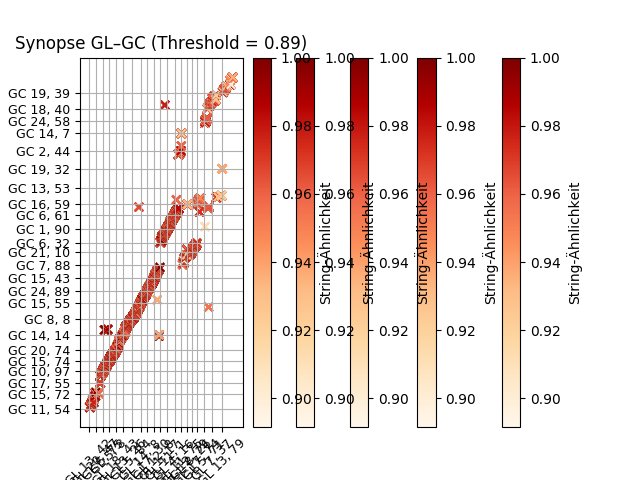

(array([7197., 1600.,  701.,  489.,  494.,  502.,  523.,  666., 1600.,
        3729.]),
 array([0.60215054, 0.64193548, 0.68172043, 0.72150538, 0.76129032,
        0.80107527, 0.84086022, 0.88064516, 0.92043011, 0.96021505,
        1.        ]),
 <a list of 10 Patch objects>)

In [566]:
sims = [i[2] for i in ratio_matrix]
n = len(sims)
plt.title("Häufigkeitsverteilung aller erfassten Ähnlichkeiten (n = {})".format(n))
plt.hist(sims,bins=10, rwidth=0.5)

In [567]:
filter_dic_gl = {}
for i in ratio_matrix:
    if i[0] in filter_dic.keys():
        if i[2] > filter_dic[i[0]]:
            filter_dic[i[0]] = i[2]
    else:
        filter_dic[i[0]] = i[2]
plt.hist(filter_dic.values(),bins=10,rwidth=0.5)        
            

(array([1891.,  712.,  477.,  435.,  471.,  490.,  517.,  664., 1593.,
        3724.]),
 array([0.60215054, 0.64193548, 0.68172043, 0.72150538, 0.76129032,
        0.80107527, 0.84086022, 0.88064516, 0.92043011, 0.96021505,
        1.        ]),
 <a list of 10 Patch objects>)

## Transpositionsvektoren

In [451]:
deltas = []
diff = 0
I,J = 0,0
for i,j,k in ratio_matrix:
    if k > 0.98:
        if not j-i == diff:
            print("GL {gl_c} {gl_o},{gl_v} == > GC {gc_c} {gc_o},{gc_v} \t Δ = {t}".format(
                gl_c=out['Gerusalemme liberata'][i]['canto'],
                gl_o=out['Gerusalemme liberata'][i]['ottava'],
                gl_v=out['Gerusalemme liberata'][i]['verso'],
                gc_c=out['Gerusalemme conquistata'][j]['canto'],
                gc_o=out['Gerusalemme conquistata'][j]['ottava'],
                gc_v=out['Gerusalemme conquistata'][j]['verso'],
                t=j-i
            ))
            diff = j-i
            diff_GC = j-J
            diff_GL = i-I
            print(diff_GL,diff_GC)
            I,J = i,j
           
        deltas.append(diff)

GL 1 9,7 == > GC 1 12,7 	 Δ = 24
70 94
GL 1 15,2 == > GC 1 19,2 	 Δ = 32
43 51
GL 1 21,3 == > GC 1 24,3 	 Δ = 24
49 41
GL 1 24,5 == > GC 1 28,5 	 Δ = 32
26 34
GL 1 40,1 == > GC 1 46,1 	 Δ = 48
124 140
GL 1 44,4 == > GC 1 49,4 	 Δ = 40
35 27
GL 1 46,5 == > GC 1 58,5 	 Δ = 96
17 73
GL 1 49,1 == > GC 1 60,1 	 Δ = 88
20 12
GL 1 50,2 == > GC 1 71,2 	 Δ = 168
9 89
GL 1 61,1 == > GC 1 85,1 	 Δ = 192
87 111
GL 1 66,5 == > GC 1 97,5 	 Δ = 248
44 100
GL 1 71,6 == > GC 1 98,6 	 Δ = 216
41 9
GL 1 74,1 == > GC 1 100,1 	 Δ = 208
19 11
GL 1 79,1 == > GC 1 103,1 	 Δ = 192
40 24
GL 1 85,1 == > GC 2 8,1 	 Δ = 368
48 224
GL 1 89,7 == > GC 2 13,7 	 Δ = 376
38 46
GL 2 57,7 == > GC 2 89,7 	 Δ = 520
464 608
GL 2 60,7 == > GC 3 55,7 	 Δ = 968
24 472
GL 2 63,8 == > GC 3 59,8 	 Δ = 976
25 33
GL 2 67,6 == > GC 3 64,6 	 Δ = 984
30 38
GL 2 88,5 == > GC 3 86,5 	 Δ = 992
167 175
GL 2 96,1 == > GC 3 93,1 	 Δ = 984
60 52
GL 3 9,7 == > GC 4 18,7 	 Δ = 1056
86 158
GL 3 19,8 == > GC 7 42,8 	 Δ = 3551
81 2576
GL 3 22,2 ==

<IPython.core.display.Javascript object>


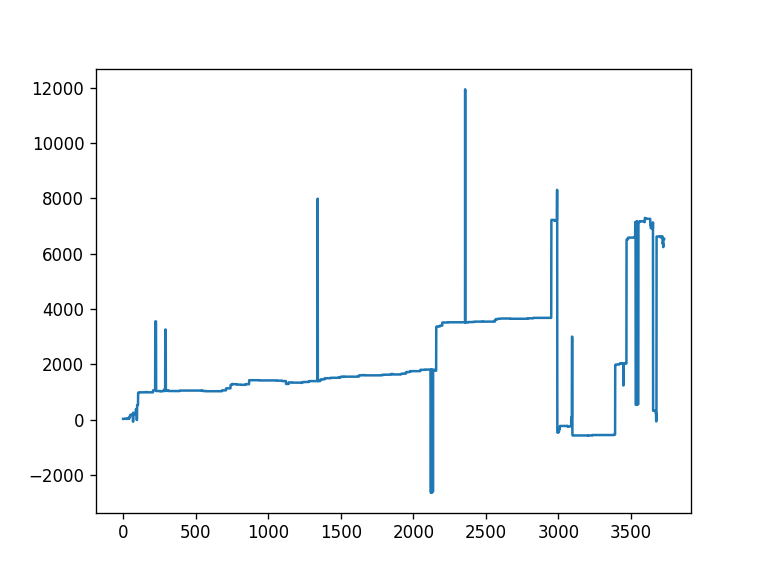

In [157]:
plt.plot(deltas)

## Visualisierung

In [584]:
thresh = 0.89

In [585]:
x = [int(i[0]) for i in ratio_matrix if float(i[2]) > thresh]
y = [int(i[1]) for i in ratio_matrix  if float(i[2]) > thresh]
z = [float(i[2]) for i in ratio_matrix if float(i[2]) > thresh]

In [586]:
x_list = ["GL "+i['canto'] for i in out['Gerusalemme liberata']]
y_list = ["GC "+i['canto'] for i in out['Gerusalemme conquistata']]
x_ticks = dict([(x_list.index(i),i) for i in set(x_list)])
y_ticks = dict([(y_list.index(i),i) for i in set(y_list)])

<IPython.core.display.Javascript object>


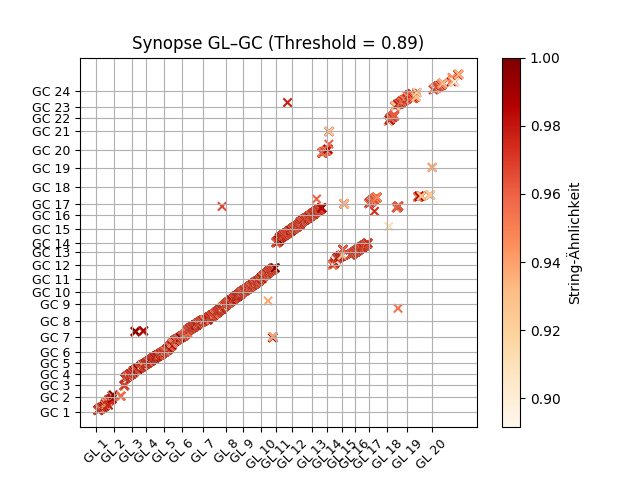

In [590]:
plt.scatter(x,y,c=z,cmap='OrRd',marker="x")
plt.xticks(list(x_ticks.keys()), x_ticks.values(), fontsize=9, rotation=45)
plt.yticks(list(y_ticks.keys()), y_ticks.values(), fontsize=9)
plt.grid(True)
plt.title("Synopse GL–GC (Threshold = {})".format(thresh))
plt.colorbar(label='String-Ähnlichkeit')
plt.show()

Alexander Winkler, 22.3.2020 ![CC-BY](https://i.creativecommons.org/l/by-nc/4.0/88x31.png) 

In [606]:
import epitran
import string
epi = epitran.Epitran('ita-Latn')

Gerusalemme Liberata

In [621]:
gl_ipa = []
for i in out['Gerusalemme liberata']:
    ipa_verse = epi.transliterate(i['testo'], normpunc=True, ligatures=True)
    ipa_verse = ipa_verse.strip()
    ipa_verse = ipa_verse.translate(str.maketrans('','',string.punctuation))
    gl_ipa.append(ipa_verse)

In [647]:
gl_ipa_rev = [i[::-1] for i in gl_ipa]
reimwoerter = [i[::-1].split()[-1] for i in sorted(gl_ipa_rev)]
collections.Counter(reimwoerter).most_common()

[('–', 367),
 ('parte', 60),
 ('morte', 46),
 ('forte', 43),
 ('volto', 41),
 ('fronte', 38),
 ('mano', 37),
 ('vede', 36),
 ('ʧelo', 36),
 ('kore', 34),
 ('vita', 33),
 ('petːo', 31),
 ('mura', 29),
 ('ʤenti', 29),
 ('ɡuerːa', 28),
 ('sole', 28),
 ('porte', 28),
 ('sorte', 28),
 ('seno', 28),
 ('loro', 28),
 ('kura', 27),
 ('reɲo', 27),
 ('terːa', 26),
 ('faʧːa', 26),
 ('viene', 26),
 ('ʤente', 26),
 ('viso', 26),
 ('fede', 25),
 ('ʤorno', 25),
 ('zdeɲo', 25),
 ('monte', 24),
 ('pote', 24),
 ('stesːo', 24),
 ('insieme', 23),
 ('sono', 23),
 ('mente', 22),
 ('move', 22),
 ('faʧe', 22),
 ('fianko', 22),
 ('foko', 22),
 ('loko', 22),
 ('resta', 21),
 ('parole', 21),
 ('piano', 21),
 ('pieno', 21),
 ('ritorno', 21),
 ('fero', 21),
 ('kanto', 21),
 ('ʤira', 20),
 ('piede', 20),
 ('suoi', 20),
 ('lontano', 20),
 ('korso', 20),
 ('mira', 19),
 ('sede', 19),
 ('franko', 19),
 ('dono', 19),
 ('vɔlto', 19),
 ('pianto', 19),
 ('intanto', 19),
 ('kuesta', 18),
 ('kiede', 18),
 ('tende', 18),
 ('i

In [659]:
r = []
for i in out['Gerusalemme liberata']:
    if i['canto'] == '1' and i['ottava'] == '1':
        s = re.findall('\w+',i['testo'])[-1]
        r.append(s)

In [668]:
import itertools
from difflib import SequenceMatcher 
list(itertools.combinations(r,2))
#        seqMatch = SequenceMatcher(None,i,j)
 #       match = seqMatch.find_longest_match(0,len(i),0,len(j)
                                    #       )
  #      print(i,j,i[match.a:match.a + match.size])

[('capitano', 'Cristo'),
 ('capitano', 'mano'),
 ('capitano', 'acquisto'),
 ('capitano', 'vano'),
 ('capitano', 'misto'),
 ('capitano', 'santi'),
 ('capitano', 'erranti'),
 ('Cristo', 'mano'),
 ('Cristo', 'acquisto'),
 ('Cristo', 'vano'),
 ('Cristo', 'misto'),
 ('Cristo', 'santi'),
 ('Cristo', 'erranti'),
 ('mano', 'acquisto'),
 ('mano', 'vano'),
 ('mano', 'misto'),
 ('mano', 'santi'),
 ('mano', 'erranti'),
 ('acquisto', 'vano'),
 ('acquisto', 'misto'),
 ('acquisto', 'santi'),
 ('acquisto', 'erranti'),
 ('vano', 'misto'),
 ('vano', 'santi'),
 ('vano', 'erranti'),
 ('misto', 'santi'),
 ('misto', 'erranti'),
 ('santi', 'erranti')]

Gerusalemme Conquistata

In [645]:
gc_ipa = []
for i in out['Gerusalemme conquistata']:
    ipa_verse = epi.transliterate(i['testo'], normpunc=True, ligatures=True)
    ipa_verse = ipa_verse.strip()
    ipa_verse = ipa_verse.translate(str.maketrans('','',string.punctuation))
    gc_ipa.append(ipa_verse)

In [646]:
gc_ipa_rev = [i[::-1] for i in gc_ipa]
reimwoerter_gc = [i[::-1].split()[-1] for i in sorted(gc_ipa_rev)]
collections.Counter(reimwoerter_gc).most_common()

[('parte', 73),
 ('ɡuerːa', 60),
 ('terːa', 57),
 ('fronte', 50),
 ('ʧelo', 46),
 ('morte', 45),
 ('ʤorno', 44),
 ('volto', 41),
 ('korso', 39),
 ('reɲo', 39),
 ('seno', 38),
 ('intorno', 35),
 ('forte', 34),
 ('sanɡue', 33),
 ('mano', 33),
 ('adorno', 33),
 ('periʎo', 33),
 ('sole', 32),
 ('duʧe', 32),
 ('monte', 31),
 ('insieme', 30),
 ('sorte', 30),
 ('ʤenti', 30),
 ('petːo', 30),
 ('vita', 29),
 ('lanɡue', 29),
 ('mondo', 29),
 ('viso', 29),
 ('zdeɲo', 29),
 ('forsa', 28),
 ('kore', 28),
 ('luʧe', 28),
 ('fianko', 28),
 ('faʧːa', 27),
 ('vede', 27),
 ('dorso', 27),
 ('mura', 25),
 ('skuadre', 25),
 ('voʧe', 25),
 ('pasːi', 25),
 ('varko', 25),
 ('velo', 25),
 ('pasːo', 25),
 ('superba', 24),
 ('ʤira', 24),
 ('vista', 24),
 ('ʤente', 24),
 ('porte', 24),
 ('spoʎe', 24),
 ('tempi', 24),
 ('amiko', 24),
 ('piano', 24),
 ('asːalto', 24),
 ('terɡo', 24),
 ('konsiʎo', 24),
 ('palma', 23),
 ('destra', 23),
 ('kura', 23),
 ('oʃura', 23),
 ('feroʧe', 23),
 ('antiko', 23),
 ('ʤelo', 23),
 ('

In [609]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'